## Final Task:
This is your final evaluation for the project. As decided, we will be predicting images of people into three classes: `without_mask`, `mask_weared_incorrect` and `with_mask`. 

In [1]:
import tensorflow as tf

### Loading the dataset
Make a copy of the dataset given to you in your Google Drive (keep it outside, don't put it in any folder to avoid inconvenience). Ensure it is named as `Mask_Dataset` or change the path (the variable `data_dir`) accordingly.

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pathlib

path='/content/drive/MyDrive/Mask_Dataset/'
data_dir = pathlib.Path(path)

### Know the Dataset
Most of the code is written for you as you aren't used to these libraries. You are to go through the documentation for your benefit.

In [4]:
# Print image count
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8982


In [5]:
# Print Output Labels
import os
output_classes = os.listdir(data_dir)
print(output_classes)

['without_mask', 'mask_weared_incorrect', 'with_mask']


[2994, 2994, 2994]


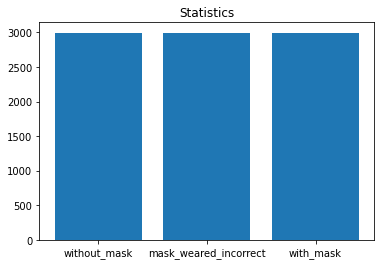

In [6]:
# Plot count of each ouput label
import matplotlib.pyplot as plt

count=[]
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  count.append(len(im_count))

print(count)

plt.bar(output_classes,count)
plt.title("Statistics")
plt.show()

In [7]:
# Check some sample images (Use of cv2)
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# cv2.imread(str())
# Your code


In [8]:
image_all = list(data_dir.glob('*/*.png'))
image_all[:4]
len(image_all)

8982

In [9]:
image_without_mask = list(data_dir.glob('without_mask/*'))
image_mask_weared_incorrect = list(data_dir.glob('mask_weared_incorrect/*'))
image_with_mask = list(data_dir.glob('with_mask/*'))

In [10]:
all_images_dict = {
    'without_mask' : image_without_mask,
    'mask_weared_incorrect' : image_mask_weared_incorrect,
    'with_mask' : image_with_mask,
}
all_images_labels = {
    'without_mask' : 0,    'mask_weared_incorrect' : 1,
    'with_mask' : 2,
}

In [11]:
import random
random.shuffle(image_all)
image_all[:6]

[PosixPath('/content/drive/MyDrive/Mask_Dataset/mask_weared_incorrect/903.png'),
 PosixPath('/content/drive/MyDrive/Mask_Dataset/without_mask/1082.png'),
 PosixPath('/content/drive/MyDrive/Mask_Dataset/mask_weared_incorrect/1862.png'),
 PosixPath('/content/drive/MyDrive/Mask_Dataset/without_mask/892.png'),
 PosixPath('/content/drive/MyDrive/Mask_Dataset/mask_weared_incorrect/211.png'),
 PosixPath('/content/drive/MyDrive/Mask_Dataset/with_mask/2567.png')]

In [12]:
X, y = [], []

for mask_type, images in all_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X.append(resized_img)
        y.append(all_images_labels[mask_type])

2


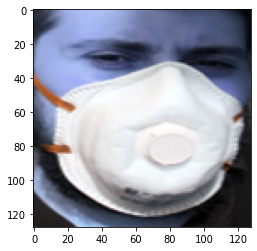

In [13]:
import matplotlib.pyplot as plt
plt.imshow(X[6000])
print(y[6000])
## 2 means mask weared

1


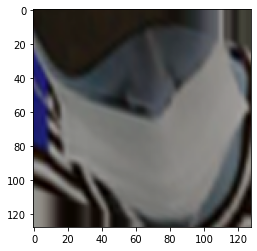

In [14]:
plt.imshow(X[3000])
print(y[3000])
## 1 means mask weared incorrectly

0


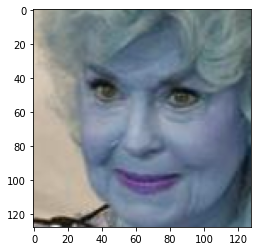

In [15]:
plt.imshow(X[1000])
print(y[1000])
## 0 means without mask

In [16]:
# Check shape of the images in your dataset. This will be helpful while specifying input_shape in your Transfer Learning Model
# shapes
shapes = []
for images in image_all:
  temp = cv2.imread(str(images))
  shapes.append(temp.shape)
shapes = np.array(shapes)
# shapes.shape
shape_uniq = np.unique(shapes,axis = 0)
shape_uniq.shape

(1, 3)

In [17]:
# Check if all the images have same shape, else you need to resize them to some common size
# The code provided as it is above in the template will help 
print(shape_uniq.reshape(-1))

[128 128   3]


In [18]:
# If the shape is variable, reshape to a common size 
# If it is same, prove it

In [19]:
print(len(image_without_mask))
print(len(image_with_mask))
print(len(image_mask_weared_incorrect))

2994
2994
2994


In [20]:
X = np.array(X)
y= np.array(y)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [23]:
X_train[0].shape

(128, 128, 3)

### Model Definition
Choose a model for Transfer Learning (You may also experment with multiple models and keep all of them in this notebook)

In [24]:
import tensorflow_hub as hub

In [25]:
# feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# pretrained_model_without_top_layer = hub.KerasLayer(
#     feature_extractor_model, input_shape=(128, 128, 3), trainable=False)

In [26]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [27]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=X_train[0].shape,
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [28]:
# Print base model summary and have a look at the layers
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [29]:
# As we're using Transfer Learning, you do not need to train all the layers. Freeze all of the layers or train some layers (experiment)

In [30]:
# Append Fully connected/custom Conv2D/Dropout/MaxPooling layers to the base model
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))

In [31]:
# Add the final output layer
resnet_model.add(Dense(3, activation='softmax'))

In [32]:
# Print your model's summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


In [33]:
# Compile you model (set the parameters like loss/optimizers/metrics)
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Data Augmentation and Pre-processing
Augment the data. You may also try dyanamic augmentation using [`tf.keras.preprocessing.image.ImageDataGenerator `](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).   
You may use [`tf.keras.applications.vgg16.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)(or some other base model's utility) for pre-processing (can also be passed as a parameter to `ImageDataGenerator`)

In [34]:
# from keras.applications.vgg16 import preprocess_input # Change according to your base model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Your code 
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2,
)
# test_datagen = ImageDataGenerator(rescale=1./255)

In [35]:
# Anything else you wish to try

### Training and Validation Dataset  
Split the dataset into training and validation (We'll be looking for your validation accuracy, assume we are using complete dataset for now). 

Hint: `flow_from_directory` used with `ImageDataGenerator` will simplify things for you.

In [36]:
# Your code
train_generator = train_datagen.flow(X_train, y_train, batch_size=32,
         subset='training')
validation_generator = train_datagen.flow(X_train, y_train,
         batch_size=8, subset='validation')

### Training  
Train your model for some epochs and plot the graph. Try and save your best model. Experiment with the parameters of `model.fit`

In [37]:
from keras.callbacks import ModelCheckpoint
# ModelCheckpoint is helpful to save the model giving best results (brownie points)

resnet_model.fit(train_generator, validation_data = validation_generator, epochs = 10)

Epoch 1/10
169/169 [==============================] - 35s 171ms/step - loss: 0.2542 - accuracy: 0.9217 - val_loss: 0.1650 - val_accuracy: 0.9406
Epoch 2/10
169/169 [==============================] - 27s 157ms/step - loss: 0.1283 - accuracy: 0.9519 - val_loss: 0.1470 - val_accuracy: 0.9562
Epoch 3/10
169/169 [==============================] - 28s 167ms/step - loss: 0.1002 - accuracy: 0.9642 - val_loss: 0.0989 - val_accuracy: 0.9659
Epoch 4/10
169/169 [==============================] - 27s 160ms/step - loss: 0.0814 - accuracy: 0.9707 - val_loss: 0.1237 - val_accuracy: 0.9592
Epoch 5/10
169/169 [==============================] - 26s 157ms/step - loss: 0.0865 - accuracy: 0.9686 - val_loss: 0.1209 - val_accuracy: 0.9592
Epoch 6/10
169/169 [==============================] - 27s 157ms/step - loss: 0.0711 - accuracy: 0.9770 - val_loss: 0.0961 - val_accuracy: 0.9710
Epoch 7/10
169/169 [==============================] - 29s 169ms/step - loss: 0.0680 - accuracy: 0.9751 - val_loss: 0.0812 - val_ac

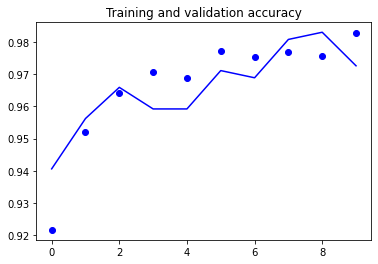

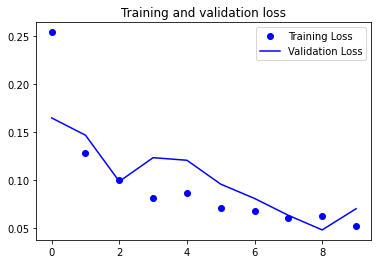

In [38]:
acc = resnet_model.history.history['accuracy']
val_acc = resnet_model.history.history['val_accuracy']
loss = resnet_model.history.history['loss']
val_loss = resnet_model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate the performance

In [39]:
# Plot training & validation loss/accuracy values

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
predictions = resnet_model.predict(X_test)
predict_class = []
for predics in predictions:
  m = np.argmax(predics)
  predict_class.append(m)
predict_class = np.array(predict_class)
predict_class
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(predict_class,y_test,target_names=target_names))
# print(classification_report(predict_class,y_test, ))
# print classification report

              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99       738
     class 1       1.00      0.95      0.98       791
     class 2       0.96      1.00      0.98       717

    accuracy                           0.98      2246
   macro avg       0.98      0.98      0.98      2246
weighted avg       0.98      0.98      0.98      2246



In [56]:
print(confusion_matrix(predict_class,y_test))

[[733   0   5]
 [ 15 755  21]
 [  1   1 715]]


In [41]:
# Use the classification report to print precision, recall, f1-score for the three classes(optional, brownie points)